In [82]:
import numpy as np
import itertools
from ldpc import bposd_decoder
from bposd.css import css_code
from random import random
import matplotlib.pyplot as plt

## Channel noise simulations on Bivariate Bicycle (BB) codes

### Establish functions for building and simulating quantum codes

In [83]:
# Credit for this cell: S. Bravyi

# Takes as input a binary matrix A
# Returns a matrix whose rows span the nullspace Ker(A) modulo two
def null2(A):
    rows,n = A.shape
    X = np.identity(n,dtype=int)

    for i in range(rows):
        y = np.dot(A[i,:], X) % 2
        not_y = (y + 1) % 2
        good = X[:,np.nonzero(not_y)]
        good = good[:,0,:]
        bad = X[:, np.nonzero(y)]
        bad = bad[:,0,:]
        if bad.shape[1]>0 :
            bad = np.add(bad,  np.roll(bad, 1, axis=1) ) 
            bad = bad % 2
            bad = np.delete(bad, 0, axis=1)
            X = np.concatenate((good, bad), axis=1)
    # now columns of X span the binary null-space of A
    return np.transpose(X)


# Takes as input a binary square matrix A
# Returns the rank of A over the binary field F_2
def rank2(A):
    rows,n = A.shape
    X = np.identity(n,dtype=int)

    for i in range(rows):
        y = np.dot(A[i,:], X) % 2
        not_y = (y + 1) % 2
        good = X[:,np.nonzero(not_y)]
        good = good[:,0,:]
        bad = X[:, np.nonzero(y)]
        bad = bad[:,0,:]
        if bad.shape[1]>0 :
            bad = np.add(bad,  np.roll(bad, 1, axis=1) ) 
            bad = bad % 2
            bad = np.delete(bad, 0, axis=1)
            X = np.concatenate((good, bad), axis=1)
    # now columns of X span the binary null-space of A
    return n - X.shape[1]

# Get an upper bound on the code distance with BP-OSD
def distance_upper_bound(gx,gz,trials=1000,max_iter=1024,osd_order=4):
    # Finds Z-type distance. Switch gx and gz for X-type distance.
    n = gz.shape[1]
    assert(n==gx.shape[1])
    gz_perp = null2(gz)
    gx_perp = null2(gx)
    d = n
    for iter in range(trials):
        # pick a random logical-X operator and promote it to X-stabilizer
        while 1:
            random_logical_x = (np.random.randint(2,size=gz_perp.shape[0]) @ gz_perp) % 2
            if np.count_nonzero(((gx_perp @ random_logical_x) % 2)>0):
                break
        augmented_gx = np.vstack([gx,random_logical_x])
        syndrome=np.zeros(augmented_gx.shape[0],dtype=int)
        syndrome[-1]=1 # we seek Z-error with the trivial stabilizer syndrome that anticommutes with random_logical_x
    
        bpd=bposd_decoder(
            augmented_gx,#the parity check matrix
            error_rate=0.01,# dummy error rate
            channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
            max_iter=max_iter, #the maximum number of iterations for BP)
            bp_method="ms",
            ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
            osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
            osd_order=osd_order #the osd search depth
            )
    
        bpd.decode(syndrome)
        low_weight_logical_z = bpd.osdw_decoding
        syndrome1 = (augmented_gx @ low_weight_logical_z) % 2
        assert(np.array_equal(syndrome,syndrome1))
        wt = np.count_nonzero(low_weight_logical_z)
        if wt>0:
            d = min(d,wt)
    return d

In [35]:
# returns the parity check matrices of a ell-by-m toric code
def toric_code(ell,m):
    n = 2*ell*m
    # define cyclic shift matrices 
    I_ell = np.identity(ell,dtype=int)
    I_m = np.identity(m,dtype=int)
    I = np.identity(ell*m,dtype=int)
    x = np.kron(np.roll(I_ell,1,axis=1),I_m)
    y = np.kron(I_ell,np.roll(I_m,1,axis=1))
    
    # define parity check matrices
    A = (np.identity(ell*m) + y) % 2
    B = (np.identity(ell*m) + x) % 2

    AT = np.transpose(A)
    BT = np.transpose(B)

    hx = np.hstack((A,B))
    hz = np.hstack((BT,AT))
    
    return hx,hz

In [43]:
# check the code parameters

hx,hz = toric_code(5,5)

print("number of qubits:", (hx.shape)[1])
print("number of encoded qubits:", (hx.shape)[1] - rank2(hx) - rank2(hz))
print("distance: <=", distance_upper_bound(hx,hz)) # X and Z type distances are the same, so we just calculate one

number of qubits: 50
number of encoded qubits: 2
distance: <= 5


In [84]:
# returns the parity check matrices of a bivariate bicycle code arXiv:2308.07915
# p1 = (a,b,c), p2 = (d,e,f)
# A = x^a + y^b + y^c
# B = y^d + x^e + x^f
def BB_code(ell,m,p1,p2):
    n = 2*ell*m
    a,b,c=p1
    d,e,f=p2
    # define cyclic shift matrices 
    I_ell = np.identity(ell,dtype=int)
    I_m = np.identity(m,dtype=int)
    I = np.identity(ell*m,dtype=int)
    x = np.kron(np.roll(I_ell,1,axis=1),I_m)
    y = np.kron(I_ell,np.roll(I_m,1,axis=1))
    
    # define parity check matrices
    A = (np.linalg.matrix_power(x,a) + np.linalg.matrix_power(y,b) + np.linalg.matrix_power(y,c)) % 2
    B = (np.linalg.matrix_power(y,d) + np.linalg.matrix_power(x,e) + np.linalg.matrix_power(x,f)) % 2

    AT = np.transpose(A)
    BT = np.transpose(B)

    hx = np.hstack((A,B))
    hz = np.hstack((BT,AT))
    
    return hx,hz

In [66]:
# check the code parameters

hx,hz = BB_code(12,6,(3,2,1),(3,2,1))

print("number of qubits:", (hx.shape)[1])
print("number of encoded qubits:", (hx.shape)[1] - rank2(hx) - rank2(hz))
print("distance: <=", distance_upper_bound(hx,hz)) # X and Z type distances are the same, so we just calculate one

number of qubits: 144
number of encoded qubits: 12
distance: <= 12


In [85]:
# generates noise with rate p on each qubit and calculates the syndrome of parity check matrix h
def generate_sample(h,p):
    r, c = h.shape
    v = np.array([1 if random()<p else 0 for i in range(c)])
    s = np.array((h@v)%2)
    return v,s

### Simulate toric codes

In [73]:
# Simualate a toric code at one physical error rate -- returns the logical failure rate

hx,hz = toric_code(7,7)

# bases for logical operators (including trivial logicals, i.e. stabilizers)
lx = null2(hz)
lz = null2(hx)

# each data point is constructed using a minimum number of samples and a minimum number of fail cases
min_samples = 1000
min_fail = 50 

p=0.05 # set a physical error rate

# create the BP decoder
bpd=bposd_decoder(
     hz, # the z-type parity check matrix
     error_rate=p,
     max_iter=1000, # max number of iterations for BP
     bp_method="ms",
     ms_scaling_factor=0,
     osd_method="osd_cs", # can find defintions of these
     osd_order=4 # last two parameters in arxiv:2005.07016
    )

N = 0
fail = 0
while fail<min_fail or N<min_samples:
    error,syndrome = generate_sample(hz,p) # introduce X noise (anticommutes with hz checks) at rate p
    bpd.decode(syndrome)
    correction = bpd.osdw_decoding
    # correction + error is guaranteed to commute with stabilizers because of osd postprocessing
    # assert(np.count_nonzero(hz@(correction+error)%2)==0) 
    if np.count_nonzero((lz@(correction+error))%2)>0: # correction + error is a logical error
        fail+=1
    N+=1

print(float(fail/N))

0.0167897918065816


In [64]:
# Simualate a toric code family over multiple physical error rates
# ****** WARNING ****** This cell takes ~1 hour to run

# these are toric codes of distances 3,5,7,9,11,13
code_family = [toric_code(m,m) for m in range(3,15,2)]

# each data point is constructed using a minimum number of samples and a minimum number of fail cases
min_samples = 1000
min_fail = 50 

data_tc={}
for i in range(len(code_family)):
    data_tc[i]=[]
    hx,hz = code_family[i]
    # bases for logical operators (including trivial logicals, i.e. stabilizers)
    lx = null2(hz)
    lz = null2(hx)
    for p in [0.03,0.05,0.07,0.09,0.11]:
        bpd=bposd_decoder(
             hz, # the z-type parity check matrix
             error_rate=p,
             max_iter=1000, # max number of iterations for BP
             bp_method="ms",
             ms_scaling_factor=0,
             osd_method="osd_cs", # can find defintions of these
             osd_order=4 # last two parameters in arxiv:2005.07016
            )
        N = 0
        fail = 0
        while fail<min_fail or N<min_samples:
            error,syndrome = generate_sample(hz,p) # introduce X noise (anticommutes with hz checks) at rate p
            bpd.decode(syndrome)
            correction = bpd.osdw_decoding
            # correction + error is guaranteed to commute with stabilizers because of osd postprocessing
            # assert(np.count_nonzero(hz@(correction+error)%2)==0) 
            if np.count_nonzero((lz@(correction+error))%2)>0: # correction + error is a logical error
                fail+=1
            N+=1
        data_tc[i].append((p,float(fail/N)))
print(data_tc)

{0: [(0.03, 0.029359953024075163), (0.05, 0.068), (0.07, 0.123), (0.09, 0.189), (0.11, 0.275)], 1: [(0.03, 0.0060805058980907215), (0.05, 0.03759398496240601), (0.07, 0.094), (0.09, 0.208), (0.11, 0.303)], 2: [(0.03, 0.002792984024131382), (0.05, 0.023234200743494422), (0.07, 0.074), (0.09, 0.189), (0.11, 0.317)], 3: [(0.03, 0.000613903690788989), (0.05, 0.011609008590666357), (0.07, 0.063), (0.09, 0.199), (0.11, 0.359)], 4: [(0.03, 0.00023027149008681235), (0.05, 0.0077724234416291), (0.07, 0.065), (0.09, 0.195), (0.11, 0.381)], 5: [(0.03, 9.785865687036272e-05), (0.05, 0.005474052988832932), (0.07, 0.056), (0.09, 0.204), (0.11, 0.42)]}


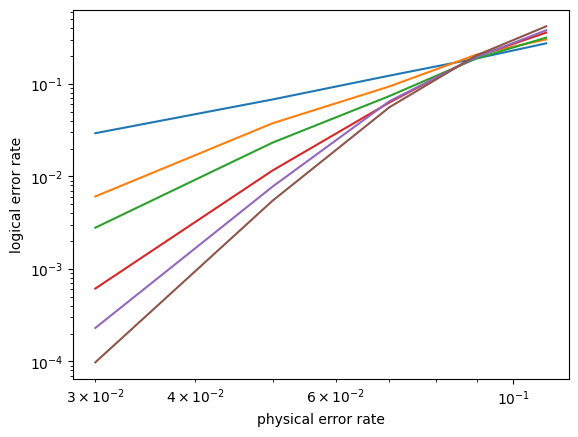

In [86]:
for i in range(len(data_tc)):
    plt.loglog([p[0] for p in data_tc[i]],[p[1] for p in data_tc[i]])
plt.ylabel('logical error rate')
plt.xlabel('physical error rate')
plt.show()

### Simulate a BB code family from arXiv:2308.07915

In [79]:
# Simualate a more general BB code family over multiple physical error rates
# ****** WARNING ****** This cell takes several hours to run

code_family = [BB_code(6,6,(3,2,1),(3,2,1)),BB_code(9,6,(3,2,1),(3,2,1)),BB_code(12,6,(3,2,1),(3,2,1))]

# each data point is constructed using a minimum number of samples and a minimum number of fail cases
min_samples = 10000
min_fail = 100

data={}
for i in range(len(code_family)):
    data[i]=[]
    hx,hz = code_family[i]
    # bases for logical operators (including trivial logicals, i.e. stabilizers)
    lx = null2(hz)
    lz = null2(hx)
    for p in [0.005,0.01,0.02,0.03,0.05,0.07,0.09,0.11]:
        bpd=bposd_decoder(
             hz, # the z-type parity check matrix
             error_rate=p,
             max_iter=1000, # max number of iterations for BP
             bp_method="ms",
             ms_scaling_factor=0,
             osd_method="osd_cs", # can find defintions of these
             osd_order=7 # last two parameters in arxiv:2005.07016
            )
        N = 0
        fail = 0
        while fail<min_fail or N<min_samples:
            error,syndrome = generate_sample(hz,p) # introduce X noise (anticommutes with hz checks) at rate p
            bpd.decode(syndrome)
            correction = bpd.osdw_decoding
            # correction + error is guaranteed to commute with stabilizers because of osd postprocessing
            # assert(np.count_nonzero(hz@(correction+error)%2)==0) 
            if np.count_nonzero((lz@(correction+error))%2)>0: # correction + error is a logical error
                fail+=1
            N+=1
        data[i].append((p,float(fail/N)))
print(data)

KeyboardInterrupt: 

In [80]:
# let it run longer (or reduce min_fail and min_samples) to get data for the last code
print(data)

{0: [(0.005, 0.0001819246904551392), (0.01, 0.0013176445785513815), (0.02, 0.0103), (0.03, 0.0329), (0.05, 0.1538), (0.07, 0.3545), (0.09, 0.5562), (0.11, 0.7509)], 1: [(0.005, 1.8470266964122435e-07), (0.01, 5.732777360941166e-06), (0.02, 0.00026720749463580957), (0.03, 0.0026456426265939995), (0.05, 0.0438), (0.07, 0.1851), (0.09, 0.4144), (0.11, 0.6587)], 2: []}
